### 1. Liraries & Dependecies

In [1]:
import numpy as np 
import pandas as pd
from scipy.optimize import curve_fit
import warnings

### 2. Data

In [2]:
df = pd.read_csv("revenue_progression.csv")
df

,age,install_date,revenue_d0,revenue_d1,revenue_d2,revenue_d3,revenue_d4,revenue_d5,revenue_d6,revenue_d7,revenue_d14,revenue_d30,revenue_d60,revenue_d90,revenue_d120,revenue_d180
0,147,2023-04-01,14420,17661,18936,20429,21391,22332,22975,23962,26203,28421,30317,31308,32256,32762
1,146,2023-04-02,14587,17234,18788,19727,20588,21296,21943,22471,24703,27510,29607,31090,31946,32491
2,145,2023-04-03,12364,16039,17805,19064,19953,20558,21044,21653,24627,27554,30435,32120,33581,34189
3,144,2023-04-04,13009,15762,17111,18172,18962,19592,20196,20721,22892,25546,27774,29088,29919,30286
4,143,2023-04-05,12034,15025,16448,17382,18273,18957,19517,20124,22587,25453,28496,29794,30832,31436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,7,2023-08-19,19975,24848,26574,27923,29073,29850,30723,31626,31626,31626,31626,31626,31626,31626
141,6,2023-08-20,21696,25858,27948,29360,30515,31615,32576,32576,32576,32576,32576,32576,32576,32576
142,5,2023-08-21,14309,18174,19949,20988,21910,22814,22814,22814,22814,22814,22814,22814,22814,22814
143,4,2023-08-22,15039,18143,19516,20637,21464,21464,21464,21464,21464,21464,21464,21464,21464,21464


### 3. Final Class

In [3]:
class LogExtrapolator:
    def __init__(self, revenue_col_prefix='revenue_d', age_col='age', prediction_day=180):
        self.revenue_col_prefix = revenue_col_prefix
        self.age_col = age_col
        self.prediction_day = prediction_day
        self.rows_with_warnings = []

    def log_func(self, x, a, b, c):
        return a + b * np.log(np.abs(x + c))

    def fit_predict(self, df):
        predicted_values = []

        for idx, row in df.iterrows():
            # Extract the age from the row
            age = row[self.age_col]

            # Dynamically select columns and days based on age
            columns_to_include = [col for col in df.columns if col.startswith(self.revenue_col_prefix) and int(col.split('_')[1][1:]) <= age]
            days_to_include = [int(col.split('_')[1][1:]) for col in columns_to_include]

            # Get the revenue values for these days from the row
            y_values = row[columns_to_include].values

            # Check if we have enough data points to fit
            if len(days_to_include) < 3:
                predicted_values.append(np.nan)
                continue

            # Initial guesses based on the nature of your data
            a_guess = y_values[0]
            b_guess = (y_values[-1] - y_values[0]) / np.log(len(y_values))
            c_guess = 1.0

            # Try to fit the data to the log function
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                params, _ = curve_fit(self.log_func, days_to_include, y_values, maxfev=10000, p0=(a_guess, b_guess, c_guess), bounds=([-np.inf, -np.inf, 0.01], [np.inf, np.inf, np.inf]))

                if len(w) > 0:  # If there's a warning
                    self.rows_with_warnings.append(idx)  # Record the index of the row that raised a warning

            # Predict for the given day
            predicted_values.append(self.log_func(self.prediction_day, *params))

        # Assign predictions to a new column in the df
        df[f'revenue_d{self.prediction_day}_predicted'] = predicted_values

        return df

In [4]:
# Usage:

# Initialize the model
model = LogExtrapolator(prediction_day = 90)

# Train the model on the entire df and get predictions for d240
df_with_predictions = model.fit_predict(df.drop(columns = ['revenue_d90','revenue_d120','revenue_d180']))


print("Rows that produced warnings:", model.rows_with_warnings)

Rows that produced warnings: []


In [5]:
df_with_predictions


,age,install_date,revenue_d0,revenue_d1,revenue_d2,revenue_d3,revenue_d4,revenue_d5,revenue_d6,revenue_d7,revenue_d14,revenue_d30,revenue_d60,revenue_d90_predicted
0,147,2023-04-01,14420,17661,18936,20429,21391,22332,22975,23962,26203,28421,30317,32261.228320
1,146,2023-04-02,14587,17234,18788,19727,20588,21296,21943,22471,24703,27510,29607,31222.448112
2,145,2023-04-03,12364,16039,17805,19064,19953,20558,21044,21653,24627,27554,30435,31992.329787
3,144,2023-04-04,13009,15762,17111,18172,18962,19592,20196,20721,22892,25546,27774,29235.524685
4,143,2023-04-05,12034,15025,16448,17382,18273,18957,19517,20124,22587,25453,28496,29919.960374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,7,2023-08-19,19975,24848,26574,27923,29073,29850,30723,31626,31626,31626,31626,41924.798853
141,6,2023-08-20,21696,25858,27948,29360,30515,31615,32576,32576,32576,32576,32576,45629.225853
142,5,2023-08-21,14309,18174,19949,20988,21910,22814,22814,22814,22814,22814,22814,32594.990989
143,4,2023-08-22,15039,18143,19516,20637,21464,21464,21464,21464,21464,21464,21464,30996.139046


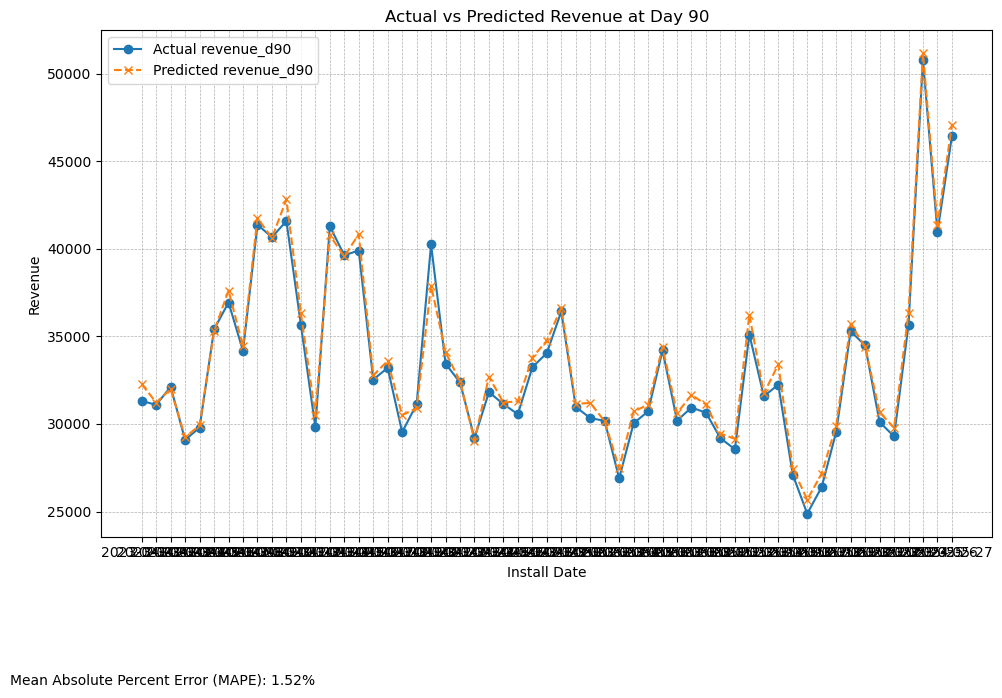

In [6]:
import matplotlib
import matplotlib.pyplot as plt

df_with_predictions['90'] = df['revenue_d90']

# Filter the DataFrame to include only rows where the age is greater than 90
df_filtered = df_with_predictions[df_with_predictions['age'] > 90]

# Define a function to compute Mean Absolute Percent Error (MAPE)
def compute_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Compute MAPE for the filtered data
mape = compute_mape(df_filtered['revenue_d90_predicted'], df_filtered['90'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['install_date'], df_filtered['90'], label='Actual revenue_d90', marker='o')
plt.plot(df_filtered['install_date'], df_filtered['revenue_d90_predicted'], label='Predicted revenue_d90', linestyle='--', marker='x')
plt.title('Actual vs Predicted Revenue at Day 90')
plt.xlabel('Install Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display MAPE below the graph
plt.figtext(0.15, -0.15, f'Mean Absolute Percent Error (MAPE): {mape:.2f}%', fontsize=10, ha='center')

plt.show()